# This notebook illustrates how to annotate a visium H&E image  


In this notebook, we will annotate the visium H&E image extracted directly from the mapped 10X folder. 
We will load the image, and annotate it using various annotation tools. There are multiple options for image annotations: (1) fully-automatic - based on gene expression level, or (2) semi-automatic - based sparse manual labeling. Both (1) and (2) are used as a basis for prediction based on a pixel classifier. Finally,  we would finalise the image annotation based on manual annotation correction.
Annotations will be saved with the extension .pkl.

In [1]:
import os
# os.environ['BOKEH_ALLOW_WS_ORIGIN']='0hu6k2kns32pmvebqpolnitgmdrp4frrrgp0kbqlu52no0hsu0l8'
os.environ['BOKEH_ALLOW_WS_ORIGIN']='*'
# os.environ['BOKEH_ALLOW_WS_ORIGIN']='localhost:8888'
import numpy as np 
from bokeh.plotting import show, output_notebook
import pandas as pd
import socket
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tissue_tag as tt
output_notebook()
host = '8888' # set the port to the value in the address bar

Loading BokehJS ...

In [2]:
# set path
path_to_tissue_tag =  # path to tissue tag main folder (e.g. c:/Users/John/Downloads/TissueTag)
path = path_to_tissue_tag + '/data/tissue_tag_minimal_example_visium/' 

## create de-novo annotations 

Load a visium image and downsample it to a more manageable size. `res_in_ppm` is the desired pixels per micron in the output.

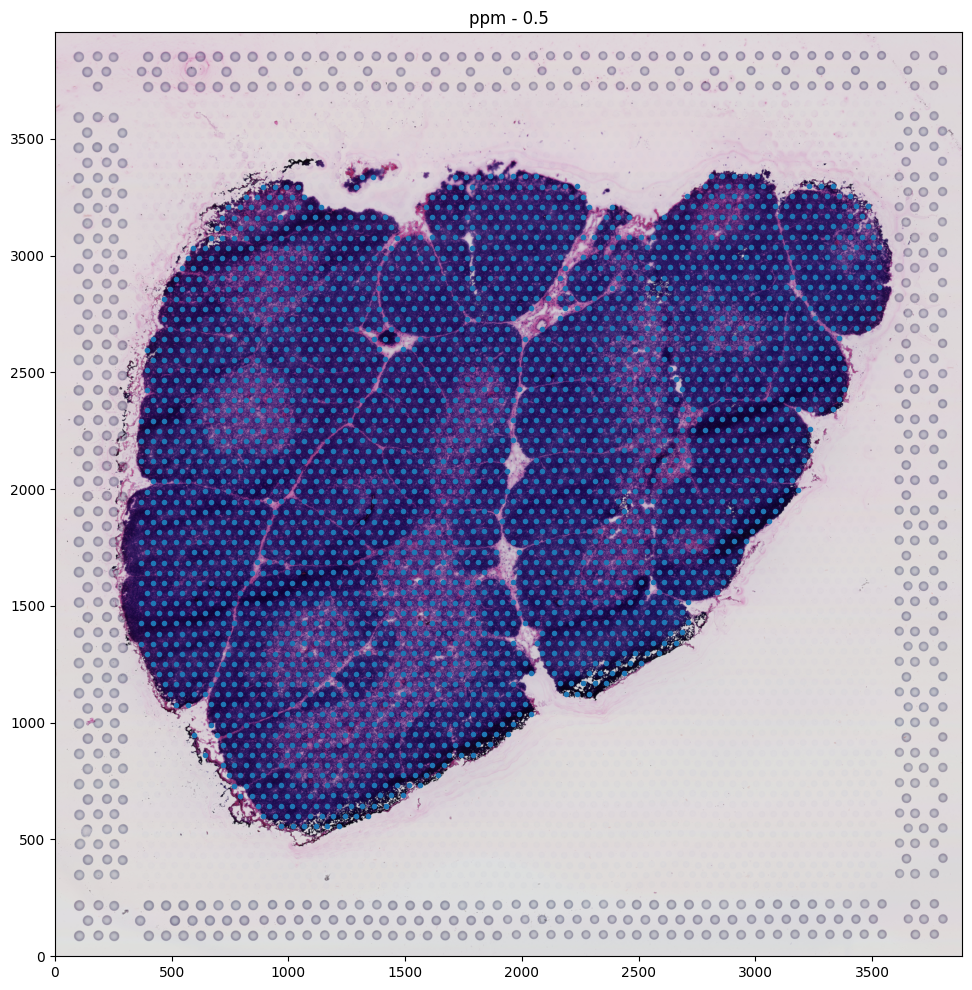

In [46]:
plt.figure(figsize=[12,12])
im,ppm_anno,df = tt.read_visium(spaceranger_dir_path=path,use_resolution='hires',res_in_ppm=0.5)

In [47]:
# define annotations 
annodict = {
    'unassigned': 'yellow',
    'Artifacts': 'black',
    'Medulla': 'green',
    'Cortex': 'cyan',
    'Edge': 'brown',
    'HS': 'magenta',
    'Vessels': 'blue',
    'PVS': 'red',
    'Other': 'orange'
}
labels = np.ones((im.shape[0],im.shape[1]), dtype=np.uint8) # blank annotation image


# Add semi automatic annotations based on gene expression 
In this option we wil use a simple random forest pixel classifier to call the cortex and medullar regions of the H&E image. The training labels will be derived based on the spots that show the highest expression of the marker gene. 

In [48]:
import scanpy as sc
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
# associate structures to genes.  *note that the name of the structures needs to correspond to the set of annotations above
gene_markers = { 
    'Medulla' : 'AIRE',
    'Cortex' : 'ARPP21',
}
labels_per_marker = { # how many spots per marker gene to derive 
    'Medulla' : 30,
    'Cortex' : 100,
}
r = 55 # radius in microns for labels 

c:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AIRE


c:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\nyayon\Anaconda3\envs\tissuetag\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


ARPP21


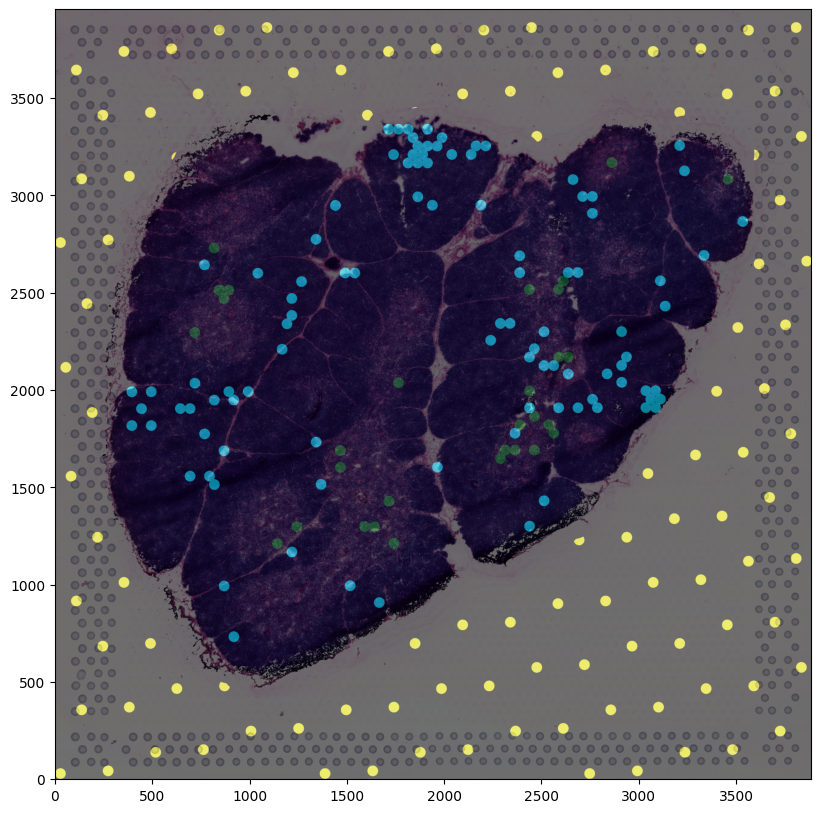

In [49]:
# generate training data from gene expression
adata = sc.read_visium(path,count_file='raw_feature_bc_matrix.h5')
adata = adata[df.index.intersection(adata.obs.index)]
coordinates = np.array(df.loc[:,['pxl_col','pxl_row']])
labels = tt.background_labels(im.shape[:2],coordinates.T,every_x_spots = 100,r=r*ppm_anno) # generate background labels 
labels = tt.gene_labels(adata,df,labels,gene_markers,annodict,r*ppm_anno,labels_per_marker) # generate gene-marker-labels
training_labels_rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
out = tt.overlay_labels(im,training_labels_rgb,alpha=0.5)

In [50]:
# (optional) add annotations for training 
p, render_dict = tt.scribbler(im,annodict)
def app(doc):
    global p
    doc.add_root(p)

import socket
show(app,notebook_url='localhost:8888') # this is on a local machine 
# show(app,notebook_url=f'{socket.gethostname()}:'+host) # this is on server 
print('wait for it.. can take a few tens of seconds on farm...')

wait for it.. can take a few tens of seconds on farm...


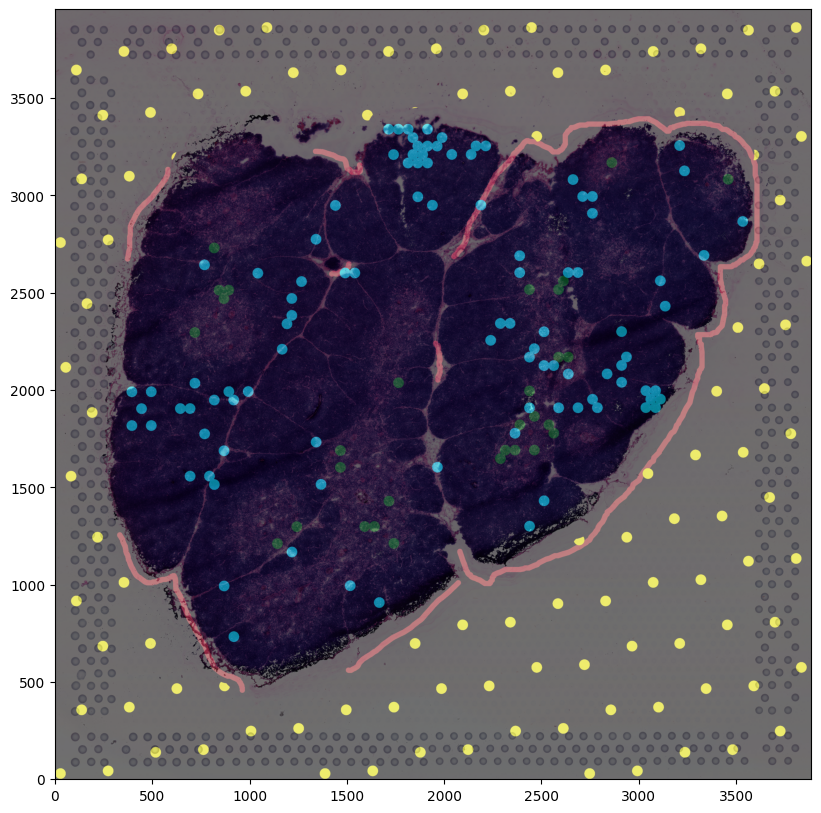

In [51]:
labels_scrib = tt.scribble_to_labels(im,render_dict,line_width=r*ppm_anno)
labels[labels==0] = labels_scrib[labels==0]
labels_rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
out = tt.overlay_labels(im,labels_rgb,alpha=0.5)

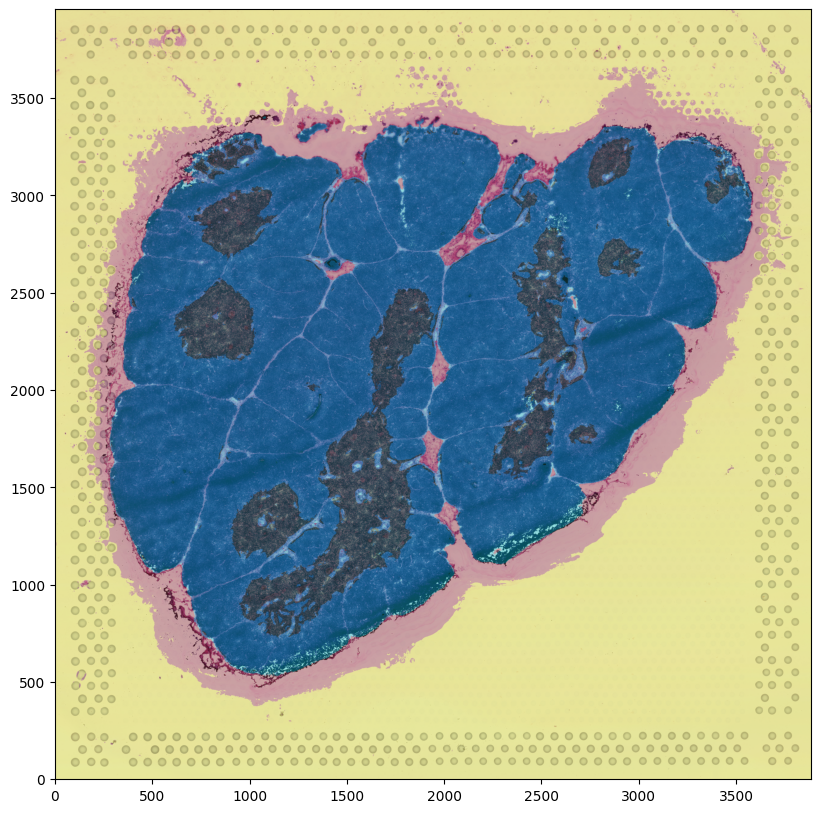

In [52]:

# run the rf classifier
labels = tt.sk_rf_classifier(im,labels)
labels_rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
out = tt.overlay_labels(im,labels_rgb,alpha=0.7)

## Manually draw or correct annotations

Manually annotate the image with the `annotator` tool:
 - You can draw closed or semi-closed objects in the interactive annotation plot. 
 - it's highly recommened to use a proper mouse and navigate with the zoom wheel funciton 
 - note thay you can flip through tabs of the reference and annotation image
 
 Happy annotating!!
 
*The interactive plot does not show within this static notebook render. see https://github.com/nadavyayon/TissueTag/blob/main/Tutorials/bokeh_plot.png for the output of this codeblock 

In [53]:
rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
anno_img = tt.overlay_labels(im,rgb,alpha=0.5,show=False)
tabs,render_dict = tt.annotator(im,anno_img,anno_dict=annodict)
# plotting
def app(doc):
    global tabs
    doc.add_root(tabs)
show(app,notebook_url=f'{socket.gethostname()}:'+host)
print('wait for it.. can take a few tens of seconds on farm... (double time of the former plot)')

wait for it.. can take a few tens of seconds on farm... (double time of the former plot)


## update and plot annotations 

Plot the annotations that were created in the interactive annotation plot.

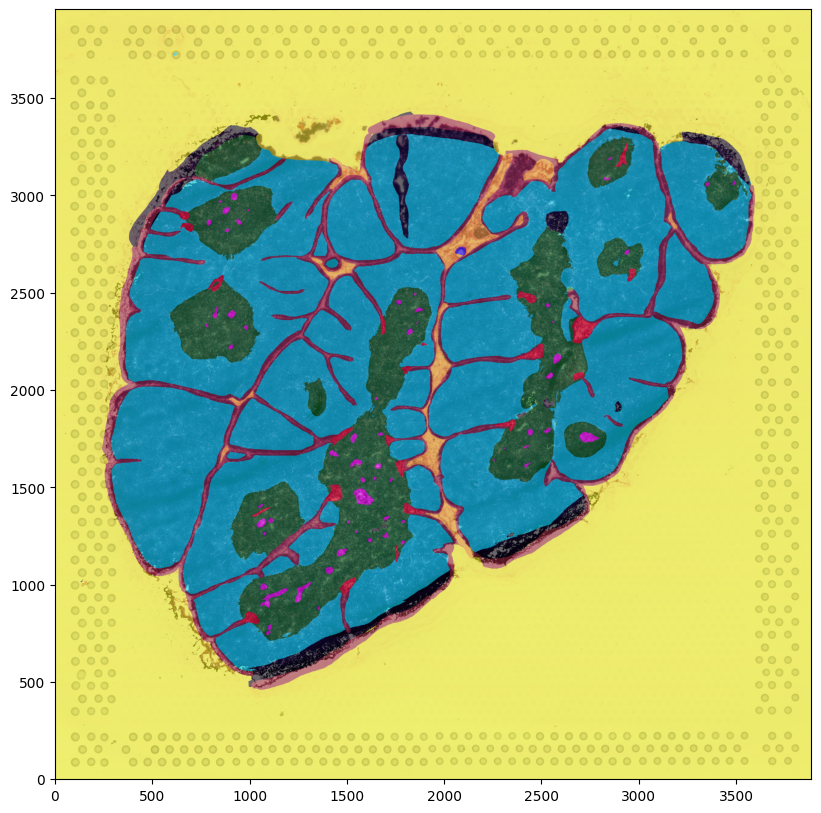

In [55]:
anno_img, labels = tt.update_annotator(im,labels,anno_dict=annodict,render_dict=render_dict,alpha=0.5)
rgb = tt.rgb_from_labels(labels,colors=list(annodict.values()))
anno_img = tt.overlay_labels(im,rgb,alpha=0.5)

## save annotation 

The resulting images and information can be saved for later use.

In [9]:
isExist = os.path.exists(path+'tissue_annotations')
if not(isExist):
    os.mkdir(path+'/tissue_annotations/')
    
tt.save_annotation(
    folder=path+'/tissue_annotations/',
    label_image=labels,
    file_name='annotations',
    anno_names=list(annodict.keys()),
    anno_colors=list(annodict.values()),
    ppm = ppm_anno
)

Done! next steps can be found in the demo_visium_map_annotation_to_spots_git notebook 